In [ ]:
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np 
import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import (r2_score, mean_squared_error)

In [59]:
instructors = pd.read_csv('Instructors.csv', sep=';')
instructors.columns = ['instructor_id', 'instructor_IsMale', 'instructor_Age']
instructors['instructor_id'] = instructors['instructor_id'].astype(str)
soc_dem = pd.read_csv('demo_satbayev.csv')
main = pd.read_csv(
    'Свежая 24.04.2021.csv', sep=';', header=None
)

main.columns = [
       'StudentID', 'SpecialityID', 'Region', 'District', 'SchoolType',
       'School', 'LabInsctructorID', 'PracticeInsctructorID',
       'LectureInsctructorID', 'CourseID', 'CourseCode',
       'PrerequisiteCourseID', 'PrerequisiteCourseCode', 'CourseTypeID',
       'CourseTypeDVOID', 'CourseCreditsNum', 'StudyYear', 'SemesterTypeID',
       'LanguageID', 'Attestation1', 'Attestation2', 'Final', 'TotalPoints',
       'LetterGrade', 'Coefficient ', 'SemesterGPA', 'YearGPA',
       'CumulativeGPA', 'Year'
]
for i in ['Attestation1','Attestation2','StudyYear','Final',]:
    main[i] = main[i].str.replace(',','.').astype(float)

for i in ['Attestation1','Attestation2']:
    main = main[
        (main[i]<=30) & (main[i]>=0)
               ]
    
main = main[
    (main.Final<=40) & (main.Final>=0)
]


main['LabInsctructorID'] = main['LabInsctructorID'].fillna('').astype(str)
main['PracticeInsctructorID'] = main['PracticeInsctructorID'].fillna('').astype(str)
main['LectureInsctructorID'] = main['LectureInsctructorID'].fillna('').astype(str)
main['instructor_id'] = main['LabInsctructorID']+','+main['PracticeInsctructorID']+','+main['LectureInsctructorID']
def instructor_parser(x):
    x = x.split(',')
    if x[2]!='':
        res=x[2]
    elif x[1]!='':
        res=x[1]
    else:
        res=x[0]
    return res
main['instructor_id'] = main['instructor_id'].apply(lambda x: instructor_parser(x))
main = main.drop(['LabInsctructorID','PracticeInsctructorID','LectureInsctructorID'], axis=1)


def flatten_multi_index(df,white_list, word):
    mi = df.columns
    suffixes, prefixes = mi.levels
    print(white_list)
    col_names = [
        word+prefixes[i_p] + '_' + suffixes[i_s] for (i_s, i_p) in zip(*mi.codes) if suffixes[i_s] not in white_list]
    df.columns = white_list + col_names
    return 0

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5,8,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# нам нужны аттестации всех первокурсников

In [60]:
df = main[main.Year==1.0]

df = df.merge(soc_dem, on='StudentID')
df = df.merge(instructors,on='instructor_id', how='left')
df = df[
    [
         'StudentID', 'IsMale',
         'Age', 'lats', 'lons',
         'CourseCode','instructor_id',
         'distance_satbayev','Attestation1','Attestation2','Final',
         'LanguageID','StudyYear',
         'instructor_IsMale','instructor_Age'
    ]
]

df['StudyYear'] = df['StudyYear'] - 1

df['instructor_id'] = df.instructor_id.astype(str) + '_' + df.StudyYear.astype(str)
df = df.drop(
    ['StudyYear'],
    axis=1
)

# lector features for each year

In [61]:
lector_features = pd.DataFrame()
for i in main.StudyYear.unique():
    temp = main[main.StudyYear<=i]
    temp['instructor_id'] = temp['instructor_id'].astype(str)+'_'+str(i)
    temp = temp.groupby('instructor_id').agg(
        {
            'Attestation1' : [
                'min', 'max', 'mean',
                'std', 'sum', 'last',
                'first'],
            'Attestation2' : [
                'min', 'max', 'mean',
                'std', 'sum', 'last',
                'first'],
            'Final' : [
                'min', 'max', 'mean',
                'std', 'sum', 'last',
                'first']
        }
    )
    lector_features = pd.concat([lector_features,temp])

flatten_multi_index(
    lector_features, [], 'instructor_'
)

lector_features = lector_features.reset_index()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[]


In [110]:
lector_features

,instructor_id,instructor_min_Attestation1,instructor_max_Attestation1,instructor_mean_Attestation1,instructor_std_Attestation1,instructor_sum_Attestation1,instructor_last_Attestation1,instructor_first_Attestation1,instructor_min_Attestation2,instructor_max_Attestation2,...,instructor_sum_Attestation2,instructor_last_Attestation2,instructor_first_Attestation2,instructor_min_Final,instructor_max_Final,instructor_mean_Final,instructor_std_Final,instructor_sum_Final,instructor_last_Final,instructor_first_Final
0,_2014.0,0.0,30.0,24.715598,5.213861,583658.85,25.2,30.0,0.0,30.0,...,597716.75,28.5,30.0,0.0,40.0,35.659441,6.819118,842097.7,38.0,40.0
1,_2016.0,0.0,30.0,23.961718,4.983152,3135151.15,18.0,30.0,0.0,30.0,...,3186922.85,21.0,30.0,0.0,40.0,31.841072,9.125086,4166085.9,28.0,40.0
2,_2015.0,0.0,30.0,24.487953,4.882295,1679530.75,18.0,30.0,0.0,30.0,...,1713834.05,21.0,30.0,0.0,40.0,34.434589,7.422868,2361730.7,28.0,40.0
3,_2013.0,0.0,30.0,24.932526,5.402035,242493.75,0.0,0.0,0.0,30.0,...,246930.15,0.0,0.0,0.0,40.0,35.667458,6.829371,346901.7,0.0,0.0
4,_2012.0,0.0,30.0,21.208288,8.361984,11643.35,0.0,28.2,0.0,30.0,...,11502.95,0.0,27.9,0.0,40.0,29.403825,12.299246,16142.7,0.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5666,_2011.0,0.0,30.0,20.845114,8.653506,6399.45,25.8,22.5,0.0,30.0,...,6219.15,25.8,23.1,0.0,40.0,29.149837,12.122079,8949.0,34.0,30.0
5667,_2007.0,0.0,30.0,22.480769,9.065377,1753.50,20.0,30.0,0.0,30.0,...,1779.90,20.0,30.0,0.0,40.0,27.846154,12.036823,2172.0,28.0,40.0
5668,_2008.0,0.0,30.0,21.951429,9.252080,2304.90,20.0,30.0,0.0,30.0,...,2361.90,20.0,30.0,0.0,40.0,28.952381,11.713225,3040.0,28.0,40.0
5669,_2005.0,0.0,30.0,24.285714,10.402610,510.00,30.0,25.0,0.0,30.0,...,510.00,30.0,25.0,0.0,38.0,26.523810,11.651691,557.0,30.0,25.0


# merge

In [62]:
df = df.merge(lector_features, on='instructor_id', how='left')

In [64]:
df['instructor_id'] = df['instructor_id'].astype(str)

In [65]:
df['target_object'] = df['StudentID'].astype(str) +'_'+df['CourseCode'].astype(str)

In [66]:
len(df['target_object'].unique()), len(df['StudentID'].unique()), len(df['CourseCode'].unique())

(48933, 4528, 2715)

In [67]:
df = df.drop_duplicates(subset=['target_object'])

In [68]:
df = df.fillna(-999)

In [418]:
df.to_csv('1kursniki_dataset.csv', index=False)

In [100]:
X = df.drop(['StudentID','CourseCode','instructor_id',
             'target_object','Attestation1','Attestation2',
            'Final'], axis=1)

y = df[['Final']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)

In [101]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34253, 29) (14680, 29) (34253, 1) (14680, 1)


In [102]:
import lightgbm as lgb

In [309]:
params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.9,
        "random_state":42,
        'max_depth': 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "bagging_frequency" : 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
       }

In [103]:
l = lgb.LGBMRegressor(n_estimators=50)

In [104]:
l.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [75]:
def metrics(model, y_test, X_test):
    print()
    print(model)
    print()
    print('***************************************')
    print ('MSE:  ', mean_squared_error(y_test, model.predict(X_test))**0.5)
    print( 'r2:   ' , r2_score(y_test, model.predict(X_test)))
    print('***************************************')

In [105]:
metrics(l, y_test, X_test)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

***************************************
MSE:   9.71009062620088
r2:    0.18842632881225252
***************************************


In [106]:
print('Максимальное предсказанное число: ', np.max(l.predict(X_test)))
print('Минимальное предсказанное число: ', np.min(l.predict(X_test)))

Максимальное предсказанное число:  38.31275140105914
Минимальное предсказанное число:  8.027196579460059


In [95]:
y_test.Attestation1.max(), y_test.Attestation1.min()

AttributeError: 'DataFrame' object has no attribute 'Attestation1'

(array([   9.,   43.,  115.,  216.,  401., 2017., 3982., 4127., 2618.,
        1152.]),
 array([ 8.02719658, 11.05575206, 14.08430754, 17.11286303, 20.14141851,
        23.16997399, 26.19852947, 29.22708495, 32.25564044, 35.28419592,
        38.3127514 ]),
 <BarContainer object of 10 artists>)

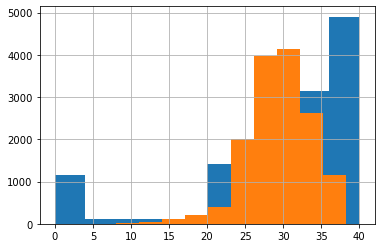

In [107]:
y_test.Final.hist()
plt.hist(l.predict(X_test))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

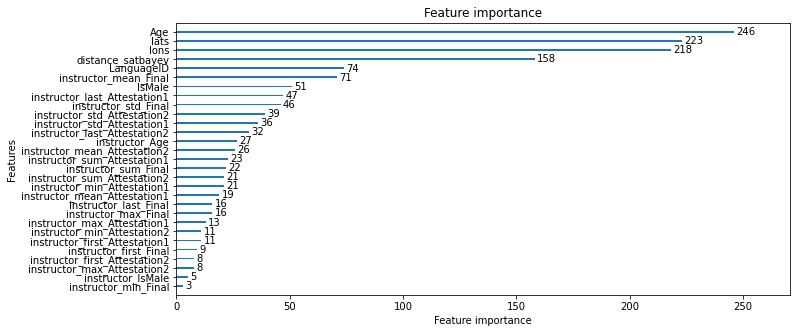

In [108]:
lgb.plot_importance(l, figsize=(11,5), grid=False, importance_type='split')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

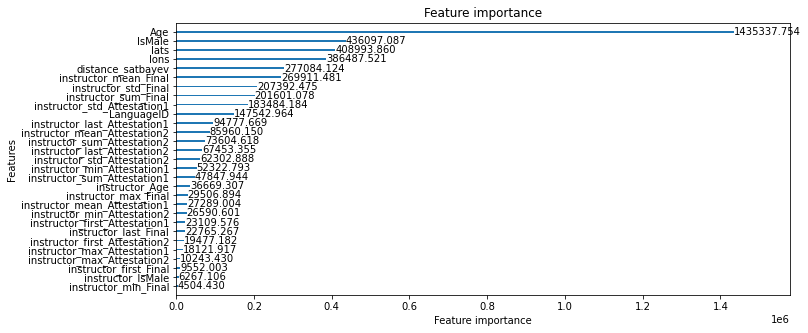

In [109]:
lgb.plot_importance(l, figsize=(11,5), grid=False, importance_type='gain')

# cross validation

In [336]:
from sklearn.model_selection import KFold

In [383]:
X_kfold, X_val, y_kfold, y_val = train_test_split(
    X, y, test_size=0.1, random_state=12)

In [384]:
kfold = KFold(n_splits=10, shuffle=False, random_state=0)

In [385]:
scores_mse = []
val_score_mse = []
r2_sc = []
val_r2_score = []

for train_index, test_index in kfold.split(X_kfold):
    print('*')
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_fold, X_test_fold = X_kfold.iloc[train_index], X_kfold.iloc[test_index]
    y_train_fold, y_test_fold = y_kfold.iloc[train_index], y_kfold.iloc[test_index]
    model = lgb.LGBMRegressor(n_estimators=50)
    model.fit(X_train_fold, y_train_fold)
    scores_mse.append(mean_squared_error(y_test_fold, model.predict(X_test_fold))**0.5)
    r2_sc.append(r2_score(y_test_fold, model.predict(X_test_fold)))
    
    val_score_mse.append(mean_squared_error(y_val, model.predict(X_val))**0.5)
    val_r2_score.append(r2_score(y_val, model.predict(X_val))**0.5)

*
TRAIN: [ 4994  4995  4996 ... 49933 49934 49935] TEST: [   0    1    2 ... 4991 4992 4993]
*
TRAIN: [    0     1     2 ... 49933 49934 49935] TEST: [4994 4995 4996 ... 9985 9986 9987]
*
TRAIN: [    0     1     2 ... 49933 49934 49935] TEST: [ 9988  9989  9990 ... 14979 14980 14981]
*
TRAIN: [    0     1     2 ... 49933 49934 49935] TEST: [14982 14983 14984 ... 19973 19974 19975]
*
TRAIN: [    0     1     2 ... 49933 49934 49935] TEST: [19976 19977 19978 ... 24967 24968 24969]
*
TRAIN: [    0     1     2 ... 49933 49934 49935] TEST: [24970 24971 24972 ... 29961 29962 29963]
*
TRAIN: [    0     1     2 ... 49933 49934 49935] TEST: [29964 29965 29966 ... 34954 34955 34956]
*
TRAIN: [    0     1     2 ... 49933 49934 49935] TEST: [34957 34958 34959 ... 39947 39948 39949]
*
TRAIN: [    0     1     2 ... 49933 49934 49935] TEST: [39950 39951 39952 ... 44940 44941 44942]
*
TRAIN: [    0     1     2 ... 44940 44941 44942] TEST: [44943 44944 44945 ... 49933 49934 49935]


In [390]:
X_val.shape[0], X_train_fold.shape[0]

(5549, 44943)

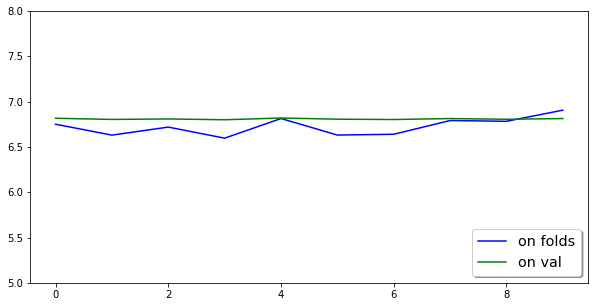

In [414]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_ylim(5,8)
ax.plot(range(0,10),scores_mse,'b', label='on folds')
ax.plot(range(0,10),val_score_mse,'g', label = 'on val')
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.show()

In [ ]:
plt.plot(range(0,10),scores_mse, )
plt.plot(range(0,10),val_score_mse)

# Таблица строгости преподавателя

In [111]:
main = pd.read_csv(
    'Свежая 24.04.2021.csv', sep=';', header=None
)

main.columns = [
       'StudentID', 'SpecialityID', 'Region', 'District', 'SchoolType',
       'School', 'LabInsctructorID', 'PracticeInsctructorID',
       'LectureInsctructorID', 'CourseID', 'CourseCode',
       'PrerequisiteCourseID', 'PrerequisiteCourseCode', 'CourseTypeID',
       'CourseTypeDVOID', 'CourseCreditsNum', 'StudyYear', 'SemesterTypeID',
       'LanguageID', 'Attestation1', 'Attestation2', 'Final', 'TotalPoints',
       'LetterGrade', 'Coefficient ', 'SemesterGPA', 'YearGPA',
       'CumulativeGPA', 'Year'
]
for i in ['Attestation1','Attestation2','StudyYear','Final',]:
    main[i] = main[i].str.replace(',','.').astype(float)

for i in ['Attestation1','Attestation2']:
    main = main[
        (main[i]<=30) & (main[i]>=0)
               ]
    
main = main[
    (main.Final<=40) & (main.Final>=0)
]

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5,8,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [119]:
p1 = main.groupby(['LectureInsctructorID','StudyYear']).agg({'Attestation1':'mean',
                                                        'Attestation2':'mean',
                                                        'Final':'mean'
                                                       
                                                       }).reset_index()
p2 = main.groupby(['LabInsctructorID','StudyYear']).agg({'Attestation1':'mean',
                                                        'Attestation2':'mean',
                                                        'Final':'mean'
                                                       
                                                       }).reset_index()
p3 = main.groupby(['PracticeInsctructorID','StudyYear']).agg({'Attestation1':'mean',
                                                        'Attestation2':'mean',
                                                        'Final':'mean'
                                                       
                                                       }).reset_index()

In [122]:
p1.columns = ['instructor_id','StudyYear','mean_Attestation1','mean_Attestation2','mean_Final']
p2.columns = ['instructor_id','StudyYear','mean_Attestation1','mean_Attestation2','mean_Final']
p3.columns = ['instructor_id','StudyYear','mean_Attestation1','mean_Attestation2','mean_Final']

In [123]:
res = pd.concat([p1,p2,p3])

In [129]:
res

,instructor_id,StudyYear,mean_Attestation1,mean_Attestation2,mean_Final
0,396,2018.0,21.046154,26.738462,33.846154
1,396,2020.0,24.500000,23.000000,33.500000
2,400,2017.0,22.761194,23.432836,33.880597
3,400,2018.0,23.017778,26.294444,33.622222
4,401,2017.0,28.952381,28.238095,37.047619
...,...,...,...,...,...
2208,54563,2020.0,30.000000,26.600000,37.600000
2209,54564,2020.0,30.000000,22.080000,30.880000
2210,54568,2020.0,30.000000,10.516667,37.500000
2211,54589,2020.0,27.600000,26.480000,34.600000
